## 1. Make sure we're using python 3.8+

In [29]:
import os
import sys

sys.path.append(os.path.expanduser("~/workspace/neuralflow"))

assert sys.version_info >= (3, 8, 0), "Python 3.8 or later required"

## 2. Import the packages / functions

In [30]:
import os
import sys
from functools import partial
from typing import Callable, Optional, Tuple, Dict

import jax
import jax.numpy as jnp
from jax import jit
from jax import value_and_grad
from jax.experimental.optimizers import adam
from jax.interpreters.xla import DeviceArray
from jax.ops import index, index_update

import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import trange

from models import kernels

## 3. Import the dataset
### (run ONLY one of the 6 cells below, depending on the dataset you'd like to run with)
- Van der Pol dataset
- Lorenz attractor dataset
- Monkey reach (jPCA) dataset
- Wide-field calcium dataset
- Mouse video dataset
- Neuropixels dataset

#### run the cell below to load the simulated Van der Pol dataset 

In [31]:
# The data loading below is the vdp with (1 trajectory, 2dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated vdp dataset. 
# You can generate the simulated data using datagen.py (more info in Readme)
data = np.load('vdp_1trajectories_2dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the simulated Lorenz attractor dataset 

In [11]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 20500 time points, with noise sd=0.05)
# Use any of the simulated lorenz dataset. 
# You can generate the simulated data using datagen.py (See README.md for more info)
data = np.load('lorenz_1trajectories_3dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the reduced Monkey reach (jPCA) dataset

In [22]:
# load the reduced Monkey reach dataset (See README.md for how the reduced dataset was generated.)
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
ys = ys[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = 6
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below to load the reduced Wide-field calcium imaging dataset

In [23]:
# load the reduced Wide-field calcium dataset (See README.md for how the reduced dataset was generated.)
data = np.load('widefield_reduced.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced Mouse video dataset

In [24]:
# load the reduced Mouse video dataset (See README.md for how the reduced dataset was generated.)
data = np.load('reduced_mouse.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example Neuropixels dataset

In [27]:
# load the reduced Neuropixels dataset with the desired latent dimensions
# (See README.md for how the reduced dataset was generated.)
data = np.load('neuropixel_reduced.npz')['ssSVD10'] # you can change this to 'ssSVD20'

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

## 4. Check your data dimension
It should be
`number of trials x number of time points x number of latent dimensions`

In [32]:
ys.shape

(1, 20000, 2)

## 5. Inline implementation of `RBFN` for modifications

In [33]:
#%%
"""
An implementation of `Interpretable Nonlinear Dynamic Modeling of Neural Trajectories`
Yuan Zhao, Il Memming Park, NIPS 2016

Equations are exact matches to those in the paper.
Generate data from a van der pol oscillator, fit with MSE, and draw vector field.
Takes ~5 ms to run per step on a 4 GHz Coffee Lake CPU.

"""


#%%
class RBFN:
    # When subclassing, don't forget class name in self._mse. Static method limitation.
    def __init__(self, ker: Callable, params, optimizer: Tuple[Callable, ...], window=100) -> None:
        assert {"W", "τ", "c", "σ"} <= params.keys()
        assert params["W"].shape == params["c"].shape
        assert params["W"].shape[0] == params["σ"].size
        assert jnp.all(params["τ"] > 0) and jnp.all(params["σ"] > 0)

        self.init_params, self.opt_update, self.get_params = optimizer
        self.opt_update = jit(self.opt_update)
        self.opt_state = self.init_params(params)

        self.ker = ker
        self._obj = self._mse_vgrad = jit(value_and_grad(self._mse, argnums=2, has_aux=True), static_argnums=0)
        self.t = 1
        self.window = window
        self.mask = jnp.zeros((self.window - 1, 1))  # For online training. -1 since this is multiplied with x[:-1].

    def reset(self):
        self.t = 1
        self.mask = jnp.zeros((self.window - 1, 1))
        
    @property
    def params(self):
        """Params are in in PyTree in self.opt_state for optimizer."""
        return self.get_params(self.opt_state)

    def g(self, x):
        return self._g(self.ker, x, self.params)

    def obj(self, x):
        return self._obj(self.ker, x, self.params)

    def step(self, x, loop=3, _mask=None, **kwargs):
        for _ in range(loop):
            (value, (dx, SE)), grads = self._obj(self.ker, x, self.params, mask=_mask, **kwargs)
            self.opt_state = self.opt_update(self.t, grads, self.opt_state)
        self.t += 1
        return value, (dx, SE)

    def step_online(self, x, loop=3, **kwargs):
        """
        Assuming the role for splitting up data for online learning for now.
        Pad for t=0...self.window.
        """
        self.mask = index_update(self.mask, self.t - 1, 1.0)
        if self.t < self.window:
            z = index_update(jnp.zeros((self.window, x.shape[1])), index[: self.t + 1, :], x[: self.t + 1, :])
        else:
            z = x[self.t : self.t + self.window]
        return self.step(z, loop, self.mask, **kwargs)

    @staticmethod
    @partial(jit, static_argnums=0)
    def _g(ker, x, p: dict):
        W, τ, c, σ = p["W"], p["τ"], p["c"], p["σ"]
        return ker(x, c, σ) @ W - jnp.exp(-(τ ** 2)) * x  # (4)

    @staticmethod
    def _mse(ker: Callable, x: DeviceArray, p: Dict[str, DeviceArray], mask: Optional[DeviceArray]):
        """||g(x_{t-1}) + x_{t-1} - x_t||²"""
        if mask is None:
            SE = jnp.square(RBFN._g(ker, x[:-1], p) + x[:-1] - x[1:])
            return jnp.mean(SE), jnp.mean(SE, axis=0)
        dx = RBFN._g(ker, x[:-1], p)
        SE = jnp.square(dx + x[:-1] - x[1:]) * mask
        return jnp.sum(SE) / jnp.sum(mask), (dx, jnp.sum(SE, axis=0) / jnp.sum(mask, axis=0))

# %%


## 6. Model hyperparameters

These are the defaults from the `neuralflow` codebase, updating these will impact logprobs

In [44]:
window = 2                # the range the RBFN model sees in each update
updates_per_input = 3     # number of Adam updates for each window
kernel = kernels.rbf      # chosen from linear, rbf, matern32, matern52
learning_rate = 2e-2      # Adam learning rate
n_rbf = 50                # number of RBF kernels
seed = 4                  # random seed

## 7. Training the model and calculating log probs

In [45]:
def initial_parameters():
    key = jax.random.PRNGKey(seed)
    return {
        "W": (W := 0.1 * jax.random.normal(key, shape=(n_rbf, ydim))),
        "τ": (τ := np.abs(jax.random.normal(key))),
        "c": (c := jax.random.normal(key, shape=(n_rbf, ydim))),
        "σ": (σ := np.ones(n_rbf) * ydim),
    }

net = RBFN(kernel, initial_parameters(), adam(learning_rate), window=window)

In [46]:
final_log_probs = []

for trial in trange(ys.shape[0]):
    yy = ys[trial]

    MSEs = []
    SEs = []
    SE_ewma = None
    dxs = []

    steps_per_epoch = yy.shape[0] - window
    TC = 10

    logprobs = []

    for epoch in range(1):
        net = RBFN(kernel, initial_parameters(), adam(learning_rate), window=window)
        with trange(steps_per_epoch, desc=f"Epochs {epoch}") as loop:
            for i in loop:
                mse, (dx, SE) = net.step_online(yy, loop=updates_per_input)
                dxs.append(dx)

                if SE_ewma is None:
                    SE_ewma = SE
                else:
                    SE_ewma = SE_ewma + 1 / TC * (SE - SE_ewma)

                logprob = -0.5 * (SE / SE_ewma + np.log(2 * SE_ewma * np.pi)).sum()  # logprob of normal distribution
                logprobs.append(logprob)

                loop.set_postfix(mse=mse, logprob=logprob)
                MSEs.append(mse)
                SEs.append(SE)
    final_log_probs.append(logprobs)

  0%|          | 0/1 [00:00<?, ?it/s]

Epochs 0:   0%|          | 0/19998 [00:00<?, ?it/s]

## 8. Save the log probabilities 

In [52]:
# use the desired file name for this
np.save('logprob_zp2016_vdp_noise0.05.npy', np.array(final_log_probs))

## 9. Plot / Save the MSEs per timestep (For Figure S5)

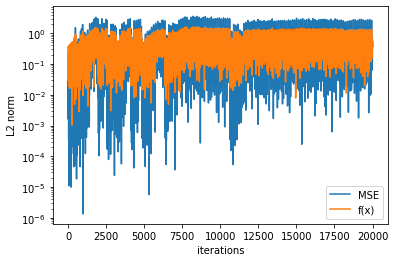

In [66]:
plt.plot(MSEs, label="MSE")
plt.plot([np.linalg.norm(dx) for dx in dxs], label="f(x)")
plt.xlabel("iterations")
plt.yscale("log")
plt.ylabel("L2 norm")
plt.legend()

In [1094]:
vdp_02_gx = np.array([np.linalg.norm(dx) for dx in dxs])
vdp_02_mse = np.array(MSEs)

## 10. Plotting the log probability 

In [54]:
# load the file you just saved from above. 
zp2016 = np.load('logprob_zp2016_vdp_noise0.05.npy')

In [58]:
# specify the trial number you want to plot.
t = 0

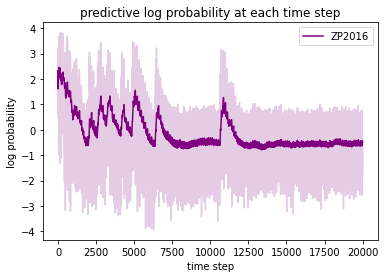

In [62]:
import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])

nn = zp2016.shape[1]

plt.plot(np.linspace(2, nn-1, nn), zp2016[t], color='purple', alpha=0.2)


ax = plt.gca()

ax.plot(np.linspace(2, nn-1, nn), ewma(zp2016[t], 100), color='purple', label='ZP2016')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('time step')
ax.set_ylabel('log probability')
ax.set_title('predictive log probability at each time step')
ax.legend(bbox_to_anchor=(1, 1))


## 11. Compute the mean and std of the last half of the time points (for Table 1)

In [65]:
zp2016[t][nn//2:].mean(), zp2016[t][nn//2:].std()

(-0.47078755, 0.8572931)

## 12. Plot the prediction error (MSE) vs predicted step size (f(x)) (for Fig S5)
In order to run this, you need to run the model for all 8 datasets.
(We used two different noise level simulations for Van der Pol and Lorenz datasets).

Repeat step 1-9 above then save the `mse` and `f(x)`s per dataset.

We saved all 8`f(x)`s in `step.npz` and all 8 `mse`s in `mse.npz`.

In [67]:
steps = np.load('step.npz')

In [68]:
mses = np.load('mse.npz')

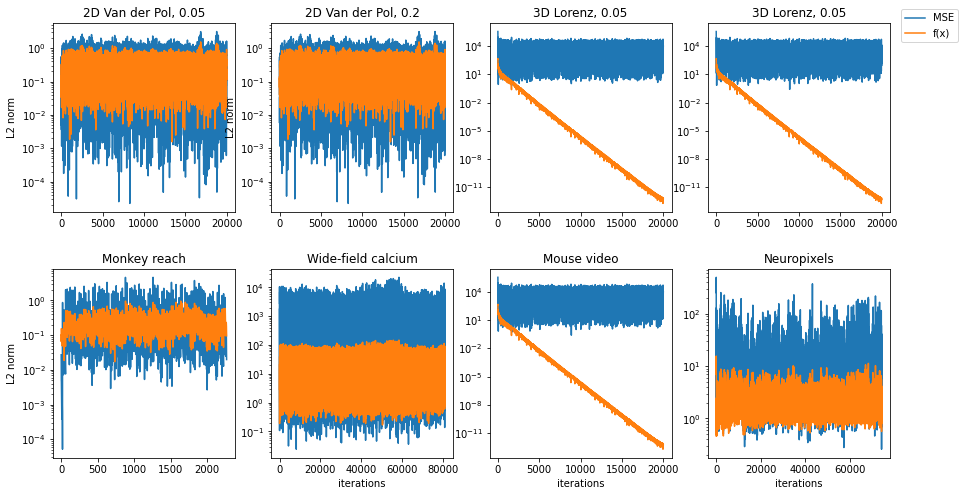

In [69]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
plt.subplots_adjust(hspace=0.3)

axs[0,0].plot(mses['vdp'], label="MSE")
axs[0,0].plot(steps['vdp'], label="f(x)")
axs[0,0].set_yscale("log")
axs[0,0].set_ylabel("L2 norm")
axs[0,0].set_title('2D Van der Pol, 0.05')

axs[0,1].plot(mses['vdp_02'], label="MSE")
axs[0,1].plot(steps['vdp_02'], label="f(x)")
axs[0,1].set_yscale("log")
axs[0,1].set_ylabel("L2 norm")
axs[0,1].set_title('2D Van der Pol, 0.2')

axs[0,2].plot(mses['lorenz'], label="MSE")
axs[0,2].plot(steps['lorenz'], label="f(x)")
axs[0,2].set_yscale("log")
axs[0,2].set_title('3D Lorenz, 0.05')

axs[0,3].plot(mses['lorenz_02'], label="MSE")
axs[0,3].plot(steps['lorenz_02'], label="f(x)")
axs[0,3].set_yscale("log")
axs[0,3].set_title('3D Lorenz, 0.05')

axs[1,0].plot(mses['jpca'], label="MSE")
axs[1,0].plot(steps['jpca'], label="f(x)")
axs[1,0].set_yscale("log")
axs[1,0].set_title('Monkey reach')
axs[1,0].set_ylabel("L2 norm")

axs[1,1].plot(mses['widefield'], label="MSE")
axs[1,1].plot(steps['widefield'], label="f(x)")
axs[1,1].set_yscale("log")
axs[1,1].set_xlabel("iterations")
axs[1,1].set_title('Wide-field calcium')

axs[1,2].plot(mses['mouse'], label="MSE")
axs[1,2].plot(steps['mouse'], label="f(x)")
axs[1,2].set_yscale("log")
axs[1,2].set_xlabel("iterations")
axs[1,2].set_title('Mouse video')

axs[1,3].plot(mses['neuropixel'], label="MSE")
axs[1,3].plot(steps['neuropixel'], label="f(x)")
axs[1,3].set_yscale("log")
axs[1,3].set_xlabel("iterations")
axs[1,3].set_title('Neuropixels')

plt.legend(bbox_to_anchor=(1.4, 2.4))
plt.savefig('steps_ver2.svg')